<H1>DoorDash Prediction model

Importing requried libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Reading data

In [2]:
historical_data = pd.read_csv("data/historical_data.csv")
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


<h4>Basic EDA on Data 

In [3]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

Convert the columns to the DateTime data for easier computation

In [4]:
from datetime import datetime

historical_data['created_at'] = pd.to_datetime(historical_data['created_at'])
historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time'])
historical_data['actual_total_delivery_duration'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()
historical_data.sample(3)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
164167,4.0,2015-02-03 19:43:35,2015-02-03 20:39:42,5501,pizza,1.0,1,1200,1,1200,1200,70.0,71.0,150.0,446,477.0,3367.0
38609,1.0,2015-01-29 00:43:09,2015-01-29 01:23:05,1548,dessert,5.0,1,788,1,609,609,18.0,18.0,25.0,251,648.0,2396.0
171069,2.0,2015-02-11 19:27:11,2015-02-11 20:25:45,162,vietnamese,2.0,3,2700,2,900,900,41.0,41.0,69.0,251,753.0,3514.0


Calculating estimated non prep time for feature engineering

In [5]:
historical_data['estimated_non_prep_duration'] = historical_data['estimated_store_to_consumer_driving_duration'] + historical_data['estimated_order_place_duration']
historical_data.sample(3)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration
174041,1.0,2015-02-05 03:33:32,2015-02-05 04:52:53,3801,american,5.0,6,4390,6,375,1095,49.0,50.0,74.0,251,345.0,4761.0,596.0
82832,1.0,2015-01-31 18:27:56,2015-01-31 19:51:54,5944,italian,5.0,1,1045,1,1045,1045,3.0,2.0,2.0,446,512.0,5038.0,958.0
111478,4.0,2015-02-11 20:09:40,2015-02-11 21:15:21,5558,sandwich,5.0,8,4780,6,195,1050,78.0,80.0,156.0,251,569.0,3941.0,820.0


Finding busy dashers using busy dashers/total onshift dashers

In [6]:
historical_data['busy_dashers_ratio'] = historical_data['total_busy_dashers'] / historical_data['total_onshift_dashers']
historical_data.sample(7)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
65304,4.0,2015-01-28 00:57:04,2015-01-28 01:33:38,6520,vietnamese,1.0,1,1145,1,995,995,69.0,61.0,73.0,446,692.0,2194.0,1138.0,0.884058
166632,1.0,2015-02-17 01:10:49,2015-02-17 02:00:34,2777,italian,1.0,3,4295,3,699,1898,4.0,4.0,4.0,446,637.0,2985.0,1083.0,1.000000
73019,1.0,2015-02-09 20:09:57,2015-02-09 21:12:17,3596,NaN,1.0,1,1149,1,1149,1149,21.0,18.0,17.0,446,224.0,3740.0,670.0,0.857143
162846,4.0,2015-01-25 21:37:37,2015-01-25 22:04:46,6569,alcohol,5.0,3,3350,3,850,1250,48.0,91.0,38.0,251,573.0,1629.0,824.0,1.895833
147701,4.0,2015-01-22 03:17:54,2015-01-22 04:12:47,5068,american,2.0,3,3889,3,1099,1495,76.0,54.0,82.0,251,693.0,3293.0,944.0,0.710526
135484,4.0,2015-01-24 19:49:33,2015-01-24 20:27:27,5112,burmese,1.0,2,2370,2,1175,1195,21.0,38.0,29.0,446,827.0,2274.0,1273.0,1.809524
72852,3.0,2015-02-02 23:10:36,2015-02-03 00:49:32,1051,fast,4.0,4,626,4,119,169,9.0,14.0,13.0,251,364.0,5936.0,615.0,1.555556


<h3>Prepring data for modeling using one hot encoding

<h4>Before that we must check which colums can be used for OHE

In [7]:
historical_data['market_id'].nunique()

6

In [8]:
historical_data['order_protocol'].nunique()

7

In [9]:
historical_data['store_id'].nunique()

6743

store_id isnt going to help us at OHE. we can procced with market_id and order_protocol

store_primary_category is another categorical feature This column includes some nulls and actually, we can fill it.

In [10]:
store_id_unique = historical_data['store_id'].unique().tolist()
store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() for store_id in store_id_unique}

In [11]:
def fill(store_id):
    """Return primary store catoegory from dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# fill null values
historical_data['nan_free_store_primary_category'] = historical_data.store_id.apply(fill)
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian


Applying OHE using getdummies


In [12]:
# dummies for order protocol
order_protocol_dummies = pd.get_dummies(historical_data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [13]:
# dummies for market id
market_id_dummies = pd.get_dummies(historical_data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies = market_id_dummies.astype(int)
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [14]:
# dummies for store primary category
store_primary_category_dummies = pd.get_dummies(historical_data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies = store_primary_category_dummies.astype(int)
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# dropping columns
train_df = historical_data.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time',
                                         'nan_free_store_primary_category', 'order_protocol'])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000


Concating the newly made columns

In [16]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)

# converting int to floast32
train_df = train_df.astype("float32")
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Having a look at the new frame

In [17]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.242188,2.670791,686.189941,1159.415405,44.808094,41.739746,58.050064,309.313446,545.358765,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.665833,1822.968994,1.629398,522.068542,558.358337,34.524193,32.146065,52.657368,90.211159,219.350143,...,0.028535,0.013687,0.073625,0.105705,0.027175,0.189502,0.034246,0.037816,0.064904,0.173167
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
train_df['busy_dashers_ratio'].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

we cant have infinite max value so we can repalce with NaN to drop them

In [19]:
np.where(np.any(-np.isfinite(train_df), axis=0) == True) # show the rows with infinite values

(array([ 5,  6,  7,  9, 10, 11, 12], dtype=int64),)

In [20]:
# replacing infinite values with null
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all NaN values
train_df.dropna(inplace=True)
train_df.shape

(177070, 100)

Check for any null values

In [21]:
# confirm no more null values
train_df.isna().sum().sum()

0

In [22]:
train_df.to_csv("data/train_df.csv", index=False)

We have a lot of features, some might not be usefull. Before we try and remove features we need to see which features are deeply correlated

<AxesSubplot:>

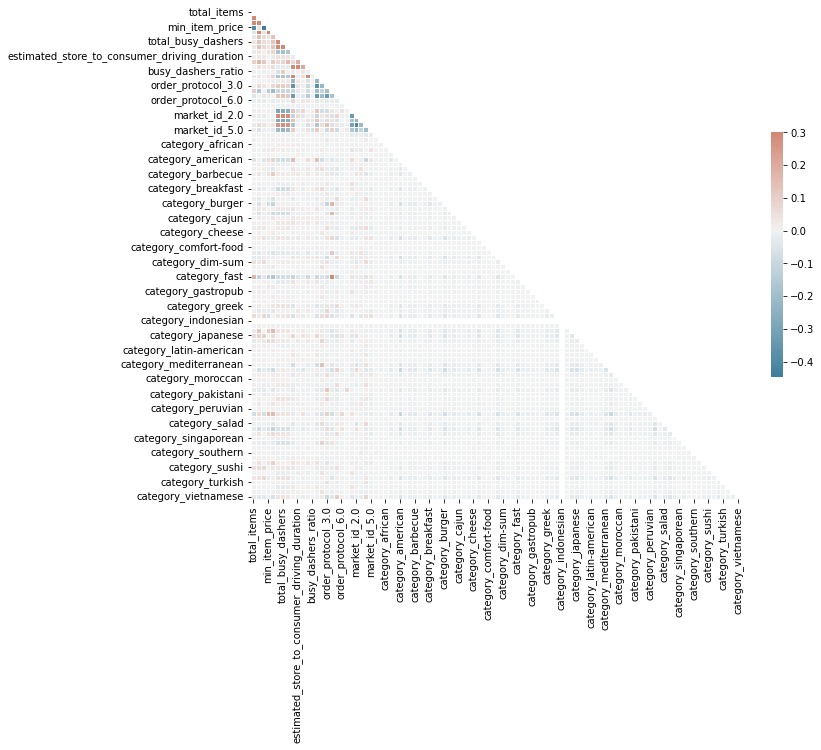

In [23]:
#correlation matrix
# creating a mask
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Indonesian catrogory seems to have blank squares

In [24]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

We can try and drop features but we need to see some of the top correlated features


In [25]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    '''Set correlations in the desscending order and return n highest results'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items          

We can drop features now

In [26]:
# droping columns
train_df = historical_data.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time',
                          'nan_free_store_primary_category', 'order_protocol'])

train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)

train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian',
                          'estimated_non_prep_duration'])

train_df = train_df.astype("float32")
# replace inf values with nan to drtop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train_df.shape

(177070, 90)

In [28]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

In [61]:
# droping columsn
train_df = historical_data.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time',
                          'nan_free_store_primary_category', 'order_protocol'])

train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)

train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian',
                          'estimated_non_prep_duration'])

train_df = train_df.astype("float32")
# replace inf values with nan to drtop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

Creating new columns for infer contributions

In [31]:
# creating new features
train_df['percent_distinct_item_of_total'] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

Doing the same for min and max item prices

In [32]:
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.15

In [33]:
train_df.shape

(177070, 82)

<h3>Multicollinearity and Feature Setting

Now we can apply a colinearity check using VIF(Variance Infaltion Factor). Having a high VIF score is undesirable, hence on chekcing we can then remove those with VID scores higher than 20

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [35]:
def compute_vif(features):
    '''Compute the VIF score using the variance_inflation_factor() function'''
    vif_data = pd.DataFrame()
    vif_data["features"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=["VIF"]).reset_index(drop=True)

In [36]:
#VIF computation on all columns
features = train_df.drop(columns=['actual_total_delivery_duration']).columns.to_list()
vif_data = compute_vif(features)
vif_data

,features,VIF
0,category_alcohol-plus-food,1.000369
1,category_chocolate,1.000488
2,category_belgian,1.000749
3,category_russian,1.003225
4,category_african,1.003820
...,...,...
76,busy_dashers_ratio,6.369592
77,category_american,7.033601
78,estimated_store_to_consumer_driving_duration,7.210812
79,estimated_order_place_duration,13.472106


In [37]:
# drop the highest VIF score and keep those below 20
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['features'].values.tolist()[-1]
    print("Remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data['VIF'] > 20]) == 0 else True

selected_features = vif_data['features'].values.tolist()
vif_data

Remove percent_distinct_item_of_total


,features,VIF
0,category_alcohol-plus-food,1.000221
1,category_chocolate,1.000361
2,category_belgian,1.000451
3,category_russian,1.002016
4,category_gluten-free,1.002363
...,...,...
75,category_american,4.505927
76,avg_price_per_item,5.958952
77,busy_dashers_ratio,6.357882
78,estimated_store_to_consumer_driving_duration,7.192612


<h2>Feature Selection

As we have a lot of features, we need to check which features are important and hence use said important features for predictions

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# selected features are selected in multicollinearity part
X = train_df[selected_features]
y = train_df['actual_total_delivery_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

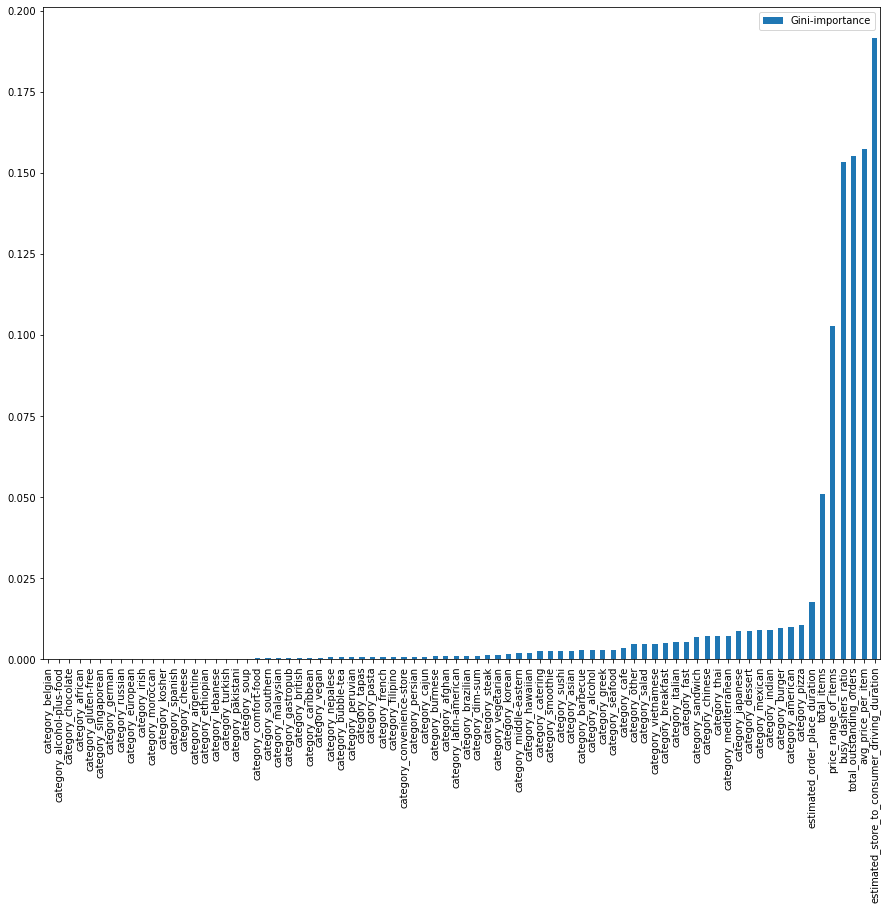

In [39]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15, 12))
plt.show();

Most Features seem unimportant, we can try and analyse the top features

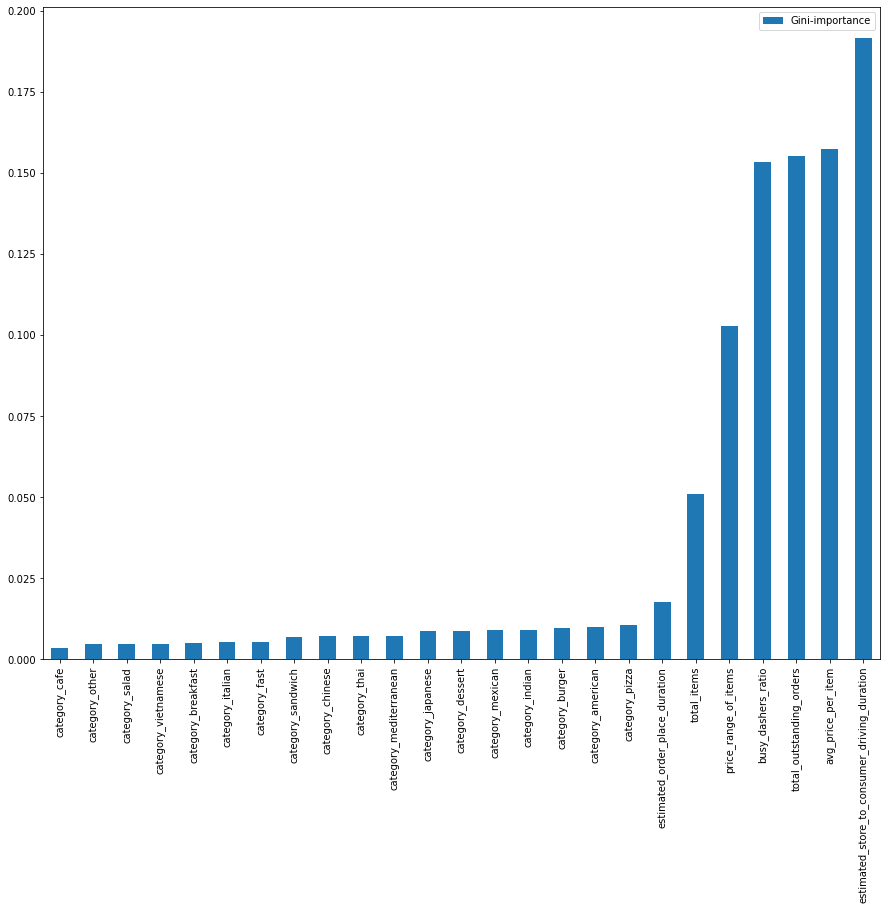

In [40]:
importances.sort_values(by='Gini-importance')[-25:].plot(kind='bar', rot=90, figsize=(15, 12))
plt.show();

In [41]:
#  column names highing high Gini Importance
importances.sort_values(by='Gini-importance')[-25:].index.tolist()

['category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

We can apply PCA(Principle Component Analysis) to reduce the number of features further

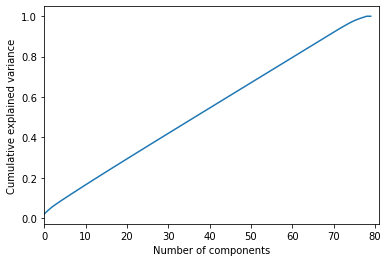

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show();

PCA tell us that close to 60 features are resposible for 80% of the dataset. This isnt ideal, hence could require feature reduction.

<h3>Applying a Scaler

As we've seen in the EDA prep, we will require to scale the data as some features have large diffrences in minimum & maximum values. The scaler will help with regression as well.

In [43]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [44]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

<h4>Inverse Transform Metric Compare

We will use RMSE(Root Mean Square Error) to calculate check for any predictions. As we've applied a scaler to the data the predictions will also need to be scaled

In [45]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    '''Convert the scaled error to actual error'''
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared error
    rmse_error = mean_squared_error(y_test, y_predict[:, 0], squared=False)
    print("Error = {}".format(rmse_error)+" in " + model_name)
    return rmse_error, y_predict

<h3>Applying machine learning alogrithms

Attempting a few machine learning algorithms to find best performing model for our problem.

In [46]:
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train Error = {}".format(train_error)+" in " + model_name)
        print("Test Error = {}".format(test_error)+" in " + model_name)
    trained_model = model

    return trained_model, y_predict, train_error, test_error

In [47]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}

regression_models = {
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth=6),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

feature_sets = {
    "full_dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(),
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():   
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            
            else:
                
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are full_dataset

Error = 2053.698549780668 in Ridge
Error = 2057.2476684096064 in DecisionTree
Error = 2048.7771433320777 in RandomForestRegressor
Error = 2036.2668882762127 in XGBoost
Error = 2033.4355810723252 in LGBM
Error = 2037.0888345867947 in MLP
-----scaled with MinMax scaler-------- included columns are full_dataset

Error = 2053.9647322776905 in Ridge
Error = 2057.247668409607 in DecisionTree
Error = 2048.0354438501004 in RandomForestRegressor
Error = 2035.760304991779 in XGBoost
Error = 2034.4499975209908 in LGBM
Error = 2122.697216727297 in MLP
-----scaled with NotScale-------- included columns are full_dataset

Train Error = 1071.4970964828283 in Ridge
Test Error = 2053.692618304535 in Ridge
Train Error = 1067.7815291116704 in DecisionTree
Test Error = 2057.2476684096064 in DecisionTree
Train Error = 397.4796316488553 in RandomForestRegressor
Test Error = 2048.735836206124 in RandomForestRegressor
Train Error = 968

C:\Users\ricdu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train Error = 1054.2445591429134 in MLP
Test Error = 2046.6972604473972 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2054.004202901983 in Ridge
Error = 2056.529202224364 in DecisionTree
Error = 2049.0681383350843 in RandomForestRegressor
Error = 2035.5541532099026 in XGBoost
Error = 2034.6538984599247 in LGBM
Error = 2038.6086516743505 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_40

Error = 2054.2792548140083 in Ridge
Error = 2056.529202224364 in DecisionTree
Error = 2049.055346349573 in RandomForestRegressor
Error = 2035.820024609826 in XGBoost
Error = 2035.1965366060547 in LGBM
Error = 2127.738368981546 in MLP
-----scaled with NotScale-------- included columns are selected_features_40

Train Error = 1072.3549699563462 in Ridge
Test Error = 2054.0043192948633 in Ridge
Train Error = 1067.785563647774 in DecisionTree
Test Error = 2056.529202224364 in DecisionTree
Train Error = 399.167441036496

C:\Users\ricdu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train Error = 1055.1966596454008 in MLP
Test Error = 2047.147839568049 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_20

Error = 2055.3656045171565 in Ridge
Error = 2054.610311170708 in DecisionTree
Error = 2049.8518200239014 in RandomForestRegressor
Error = 2037.6335937562217 in XGBoost
Error = 2036.0233846443627 in LGBM
Error = 2037.097064800256 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_20

Error = 2055.655184497439 in Ridge
Error = 2054.610311170708 in DecisionTree
Error = 2048.458152025388 in RandomForestRegressor
Error = 2037.5436623999362 in XGBoost
Error = 2035.5815163215648 in LGBM
Error = 2104.977201586073 in MLP
-----scaled with NotScale-------- included columns are selected_features_20

Train Error = 1074.5066667075766 in Ridge
Test Error = 2055.3656045086145 in Ridge
Train Error = 1069.1350906055598 in DecisionTree
Test Error = 2054.610311170708 in DecisionTree
Train Error = 398.365814686671

C:\Users\ricdu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train Error = 1058.0781851757943 in MLP
Test Error = 2048.5248958164657 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_10

Error = 2056.568358582823 in Ridge
Error = 2054.597176140608 in DecisionTree
Error = 2050.015514344455 in RandomForestRegressor
Error = 2040.2362331504632 in XGBoost
Error = 2038.13136041913 in LGBM
Error = 2039.9973996988717 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_10

Error = 2056.883865772247 in Ridge
Error = 2054.597176140608 in DecisionTree
Error = 2050.9374477773067 in RandomForestRegressor
Error = 2038.5655582259417 in XGBoost
Error = 2037.656448775817 in LGBM
Error = 2087.960884678382 in MLP
-----scaled with NotScale-------- included columns are selected_features_10

Train Error = 1076.727917636988 in Ridge
Test Error = 2056.568308194839 in Ridge
Train Error = 1069.2324011708552 in DecisionTree
Test Error = 2054.597176140608 in DecisionTree
Train Error = 400.2785575315183 in

C:\Users\ricdu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
pred_df = pd.DataFrame(pred_dict)
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full_dataset,Standard scaler,2053.698550
1,DecisionTree,full_dataset,Standard scaler,2057.247668
2,RandomForestRegressor,full_dataset,Standard scaler,2048.777143
3,XGBoost,full_dataset,Standard scaler,2036.266888
4,LGBM,full_dataset,Standard scaler,2033.435581
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2087.960885
68,RandomForestRegressor,selected_features_10,NotScale,2087.960885
69,XGBoost,selected_features_10,NotScale,2087.960885
70,LGBM,selected_features_10,NotScale,2087.960885


<AxesSubplot:>

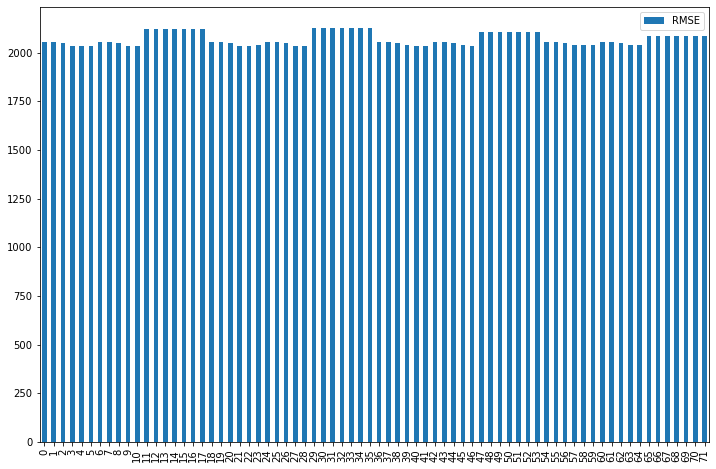

In [49]:
pred_df.plot(kind='bar', figsize=(12, 8))

Most models show high error rate. Additionally, the decrease in festure size seems to help performance of the models. Also, we can try and calcualte estimated store to consumer ration to add to delivery duration. This would require us to change the problem we are trying to solve a bit.

In [50]:
train_df["prep_time"] = train_df["actual_total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

for featue_set_name in feature_sets.keys():
    feature_set = feature_sets[featue_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_10

Error = 2055.407522978242 in Ridge
Error = 2045.9600605603337 in DecisionTree
Error = 2046.3064990745238 in RandomForestRegressor
Error = 2037.826537590277 in XGBoost
Error = 2035.7236370513838 in LGBM
Error = 2039.304375677669 in MLP


In [51]:
# not scaling affects the performance so we will continue to scale but it doesn't really matter which scaler we use

scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

regression_models = {
    "LGBM": LGBMRegressor(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2035.7236370513838 in LGBM


In [52]:
# use best performing model and extract predictions for preparation duration

pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(),
    "prep_duration_prediction": y_predict[:, 0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),
}

In [53]:
values_df = pd.DataFrame(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871827,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


In [54]:
# sum predictions with no preparation activities such as order placing and driving
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871827,691.0,446.0,3082.871827
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


In [55]:
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

2035.7236370513838

In [56]:
# what if we use another regression model to get the total delivery duration
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
regression_models = {
    "LinearReg": linear_model.LinearRegression(),
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

for model_name in regression_models.keys():
    _, y_predict, _, _ = make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

RMSE of: LinearReg 986.6912510221224
RMSE of: Ridge 986.6912510262307
RMSE of: DecisionTree 1613.541209542975
RMSE of: RandomForest 1258.0218900772204
RMSE of: XGBoost 1370.412425918564
RMSE of: LGBM 1079.2949179771774
RMSE of: MLP 987.093436248419


<h2>Deep Learning

Another method of prediction is by using deep learning models. In this case we can create a deep learnig model using a Artificial Neural Network.

In [58]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

# Neural network
def create_model(feature_set_size):
    
    # define the model
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile the model
    model.compile(optimizer='sgd', loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [59]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = "ANN"   
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:",X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

feature_set_size: 3
Epoch 1/100
443/443 [==============================] - 1s 686us/step - loss: 1.1366 - root_mean_squared_error: 1.0661
Epoch 2/100
443/443 [==============================] - 0s 676us/step - loss: 1.1195 - root_mean_squared_error: 1.0581
Epoch 3/100
443/443 [==============================] - 0s 674us/step - loss: 1.1186 - root_mean_squared_error: 1.0576
Epoch 4/100
443/443 [==============================] - 0s 629us/step - loss: 1.1185 - root_mean_squared_error: 1.0576
Epoch 5/100
443/443 [==============================] - 0s 625us/step - loss: 1.1181 - root_mean_squared_error: 1.0574
Epoch 6/100
443/443 [==============================] - 0s 674us/step - loss: 1.1182 - root_mean_squared_error: 1.0575
Epoch 7/100
443/443 [==============================] - 0s 653us/step - loss: 1.1180 - root_mean_squared_error: 1.0574
Epoch 8/100
443/443 [==============================] - 0s 669us/step -

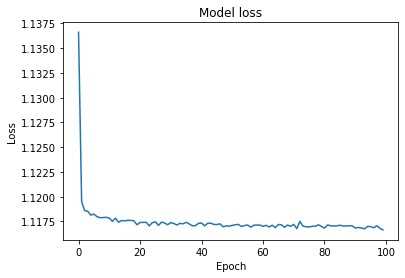

In [60]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show();

<h3>What we have learend from this analysis is that the best predictions are from the LGBM+ Linear Regression.